In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']
data=pd.read_csv('adult-training.csv',names=columns)

In [3]:
data.head()

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Again, we see there are missing values. Thus, converting them to panda readable version. 

In [4]:
data.replace(' ?', np.nan, inplace=True)
data.isnull().sum()

Age                  0
Workclass         1836
fnlgwt               0
Education            0
Education num        0
Marital Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours/Week           0
Native country     583
Income               0
dtype: int64

We do same with the **missing values** and **object --> integers** for this data.

In [5]:
for col in data.columns:
    if data[col].dtype=='object' and data[col].isnull().sum()>0:
        valcounts = data[col].value_counts()
        MostfrequentEntry = valcounts.loc[valcounts == valcounts.max()].index[0]
        data[col].replace(np.nan, MostfrequentEntry, inplace=True)
    elif data[col].dtype != 'object' and data[col].isnull().sum()>0:
        data[col].replace(np.nan,data[col].mean(), inplace=True)

In [6]:
data.isnull().sum()

Age               0
Workclass         0
fnlgwt            0
Education         0
Education num     0
Marital Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours/Week        0
Native country    0
Income            0
dtype: int64

Now, objects into integers:

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i] = le.fit_transform(data[i]) #Fit label encoder and return encoded labels
data.head()

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
0,39,6,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0


**Feature selection:**

In [8]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
X = data[data.columns[0:14]]
Y = data[data.columns[14]]
LR = LogisticRegression( C = 1e7)

Similar, recursive elimination based ranking as was done for Loan prediction dataset.

In [9]:
selector = RFECV(LR,step=1,cv=3,scoring='accuracy')
selector = selector.fit(X, Y)
print("\n")
print(np.c_[selector.ranking_,X.columns])
print(selector.grid_scores_)
print("Best number of features = {}".format(selector.n_features_))



[[1 'Age']
 [1 'Workclass']
 [2 'fnlgwt']
 [1 'Education']
 [1 'Education num']
 [1 'Marital Status']
 [1 'Occupation']
 [1 'Relationship']
 [1 'Race']
 [1 'Sex']
 [1 'Capital Gain']
 [1 'Capital Loss']
 [1 'Hours/Week']
 [1 'Native country']]
[0.75919044 0.78572541 0.80725416 0.807592   0.80660922 0.8065478
 0.80439796 0.80642491 0.80513503 0.80538072 0.80547286 0.80648634
 0.82417624 0.79847075]
Best number of features = 13


In this case, almost all features are important. Let's try to see the most important 4 features.

In [10]:
from sklearn.feature_selection import RFE
selector = RFE(LR)
selector = selector.fit(X, Y)
print("\n")
print(np.c_[selector.ranking_,X.columns])



[[1 'Age']
 [1 'Workclass']
 [8 'fnlgwt']
 [3 'Education']
 [1 'Education num']
 [1 'Marital Status']
 [4 'Occupation']
 [1 'Relationship']
 [1 'Race']
 [1 'Sex']
 [7 'Capital Gain']
 [6 'Capital Loss']
 [2 'Hours/Week']
 [5 'Native country']]


Well, still 7 of features are at least important. **Accuracy behavior on the training dataset:**

In [11]:
from sklearn.metrics import accuracy_score
print('Features   :  Accuracy score')
for index in range(1,len(selector.ranking_)):
    X_red=X[X.columns[selector.ranking_<=index]]
    LR.fit(X_red,Y)
    prediction=LR.predict(X_red)
    accuracy=accuracy_score(prediction,Y)
    print(X.columns[selector.ranking_<=index].tolist(),': '+str(accuracy))

Features   :  Accuracy score
['Age', 'Workclass', 'Education num', 'Marital Status', 'Relationship', 'Race', 'Sex'] : 0.8047050152022358
['Age', 'Workclass', 'Education num', 'Marital Status', 'Relationship', 'Race', 'Sex', 'Hours/Week'] : 0.8066091336261171
['Age', 'Workclass', 'Education', 'Education num', 'Marital Status', 'Relationship', 'Race', 'Sex', 'Hours/Week'] : 0.8050428426645373
['Age', 'Workclass', 'Education', 'Education num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Hours/Week'] : 0.8055035164767667
['Age', 'Workclass', 'Education', 'Education num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Hours/Week', 'Native country'] : 0.8055649396517306
['Age', 'Workclass', 'Education', 'Education num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Loss', 'Hours/Week', 'Native country'] : 0.8066091336261171
['Age', 'Workclass', 'Education', 'Education num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 

Here the accuracy behavior is quite complicated. Almost all features seem to effect the accuracy in some way. Let's just take the four feature from the rank 1 and see some plots.

In [12]:
impcolumns=['Age', 'Workclass', 'Education num', 'Marital Status']

In [13]:
import nbimporter
import Irisdataset as Plotter

Importing Jupyter notebook from Irisdataset.ipynb


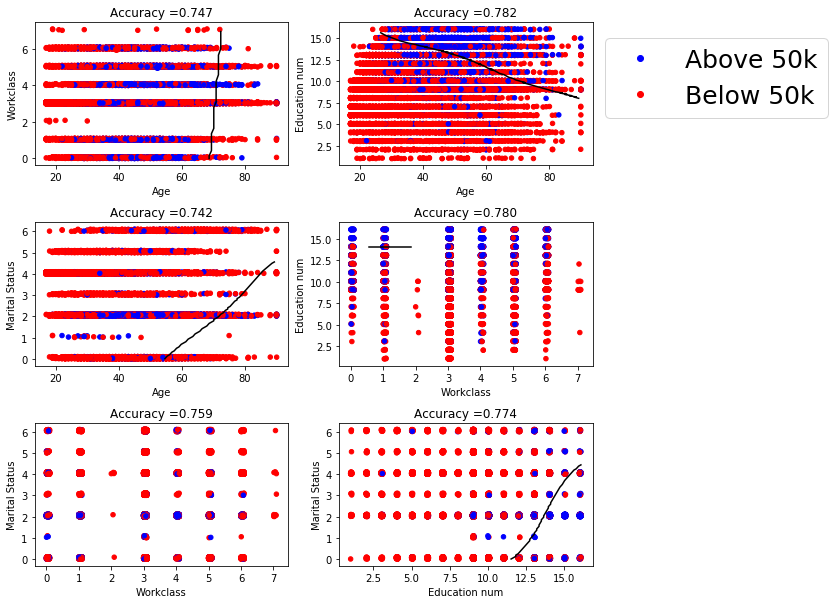

In [14]:
X_red=X[impcolumns]
X_red += np.random.rand(X_red.shape[0],X_red.shape[1])*0.1
ColormapforY = Y.copy()
ColormapforY.replace(0.0,'r', inplace=True)
ColormapforY.replace(1.0,'b', inplace=True)
axes=Plotter.plotfeatures(X_red, ColormapforY,decision_boundary=True, model=LR,Y=Y)
Plotter.addlabels(X,ColormapforY,axes,{'r':'Below 50k','b':'Above 50k'})

Just to make sure that decision boundaries are calculated correctly, Let us try the full filled version.

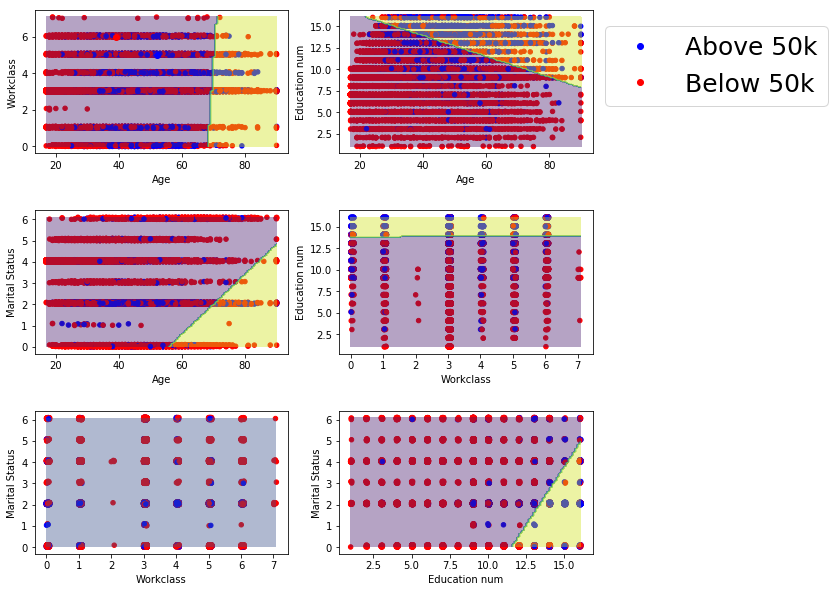

In [15]:
axes=Plotter.plotfeatures(X_red, ColormapforY,decision_boundary=True,solid=True,model=LR,Y=Y)
Plotter.addlabels(X,ColormapforY,axes,{'r':'Below 50k','b':'Above 50k'})

Due to relevance of all the features the decision boundaries and the plots are not much informative.<br>
(i) The plot between the 'Age' and 'Education num' suggests that it is more likely to have high income if the person is old and high education.<br>
Let's print all the features, other than 'fngwt' for the clean file. 

In [16]:
import csv
impcolumns=X.columns[X.columns != 'fnlgwt']
d = np.c_[X[impcolumns],Y]

header = impcolumns.tolist() +["Income"]
with open('Incomeprediction.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow((header))
    wr.writerows(d)
myfile.close()